In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=fbc6d5964206f3fa915cbe0aa39641d45d840020b6c3577eee0e2eb43c327029
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# **REVIEW 1**

# Extracting data

In [ ]:
import requests
import zipfile
import io
import wget

## downloading and extracting training data

In [ ]:
url_train = 'https://github.com/ScienceIE/scienceie.github.io/blob/master/resources/scienceie2017_train.zip?raw=true'
response = requests.get(url_train)

In [ ]:
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall()

## downloading and extracting testing data

In [ ]:
!wget https://github.com/ScienceIE/scienceie.github.io/raw/master/resources/semeval_articles_test.zip


--2024-07-24 10:11:40--  https://github.com/ScienceIE/scienceie.github.io/raw/master/resources/semeval_articles_test.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ScienceIE/scienceie.github.io/master/resources/semeval_articles_test.zip [following]
--2024-07-24 10:11:40--  https://raw.githubusercontent.com/ScienceIE/scienceie.github.io/master/resources/semeval_articles_test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146325 (143K) [application/zip]
Saving to: ‘semeval_articles_test.zip’

semeval_articles_te 100%[===================>] 142.90K  --.-KB/s    in 0.03s   

2024-07-24 10:1

In [ ]:
!unzip semeval_articles_test.zip


Archive:  semeval_articles_test.zip
   creating: semeval_articles_test/
  inflating: semeval_articles_test/S0010482516301810.ann  
  inflating: semeval_articles_test/S0010482516301810.txt  
  inflating: semeval_articles_test/S0010938X15301268.ann  
  inflating: semeval_articles_test/S0010938X15301268.txt  
  inflating: semeval_articles_test/S0010938X15301554.ann  
  inflating: semeval_articles_test/S0010938X15301554.txt  
  inflating: semeval_articles_test/S0011227514002136.ann  
  inflating: semeval_articles_test/S0011227514002136.txt  
  inflating: semeval_articles_test/S0011227515000648.ann  
  inflating: semeval_articles_test/S0011227515000648.txt  
  inflating: semeval_articles_test/S0011227515001216.ann  
  inflating: semeval_articles_test/S0011227515001216.txt  
  inflating: semeval_articles_test/S002002551630384X.ann  
  inflating: semeval_articles_test/S002002551630384X.txt  
  inflating: semeval_articles_test/S0021961414003255.ann  
  inflating: semeval_articles_test/S0021961

## downloading glove

In [ ]:
url = 'https://nlp.stanford.edu/data/glove.6B.zip'

# Directory to save the downloaded file
download_dir = './glove.6B.zip'

# Download the GloVe embeddings zip file
wget.download(url, download_dir)

# Extract the contents of the zip file
import zipfile
with zipfile.ZipFile(download_dir, 'r') as zip_ref:
    zip_ref.extractall('./')

# Preprocessing

In [ ]:
from fileinput import filename
#from msilib.schema import Class
import os
import re
import json
from turtle import st
import nltk
import unicodedata
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize, sent_tokenize
from numpy import unicode_
import spacy

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nlp = spacy.load("en_core_web_sm")


In [ ]:
def lemmatize(text):
    doc = nlp(text)
    lem_list = [token.lemma_ for token in doc]
    lem_text = ' '.join(lem_list)
    return lem_list, lem_text

In [ ]:
import os

def count_ann_files(folder_path):
    ann_count = 0
    files = os.listdir(folder_path)

    for file in files:

        if file.endswith('.ann'):
            ann_count += 1

    return ann_count

folder_path = '/content/train2'
num_ann_files = count_ann_files(folder_path)
print("Number of .ann files:", num_ann_files)


Number of .ann files: 350


In [ ]:
def read_ann(textfolder="/content/train2/"):
    json_file = dict()
    for f in os.listdir(textfolder):
        if not f.endswith(".ann"):
            continue
        filename = f.replace(".ann", "")
        ann_path = os.path.join(textfolder, f)
        text_path = os.path.join(textfolder, filename + ".txt")

        with open(text_path, "r", encoding='utf-8') as f_text:
            text = f_text.read().lower()

        # Remove punctuations
        text = re.sub(r'[^\w\s]', '', text)

        kw_dict = dict()
        with open(ann_path, "r", encoding='utf-8') as f_anno:
            for line in f_anno:
                parts = line.strip("\n").split("\t")
                if len(parts) == 3:
                    type_parts = parts[1].split(" ")
                    if len(type_parts) == 3:
                        keytype, start, end = type_parts
                    else:
                        keytype, start, _, end = type_parts
                    if not keytype.endswith("-of"):
                        key = parts[2].lower()
                        if key not in kw_dict:
                            kw_dict[key] = [[int(start), int(end), keytype]]
                        else:
                            kw_dict[key].append([int(start), int(end), keytype])

        normalized_text = unicodedata.normalize("NFKD", text) # form decomposes and combines base charecters for text normalisation and ensureing consistency
        dp_whitespace_text = re.sub(' +', ' ', normalized_text)
        lem_list, lem_text = lemmatize(normalized_text)
        json_file[filename] = {
            'text': text,
            'lem_text': lem_text,
            'lem_list': lem_list,
            'keywords': kw_dict
        }

        # Tokenize
        doc = nlp(text)
        tokens = [token.text for token in doc]
        json_file[filename]['word_tokens'] = tokens

        # Sentence Tokenize
        sent_tokens = sent_tokenize(text)
        json_file[filename]['sent_tokens'] = sent_tokens

        # Part-of-speech Tagging
        pos_tags = [[token.lemma_, token.tag_] for token in doc]
        json_file[filename]['pos'] = pos_tags

        # Chunking
        chunks = [chunk.text for chunk in doc.noun_chunks]
        json_file[filename]['chunks'] = chunks

        # Named Entity Recognition
        ner = [(ent.text, ent.label_) for ent in doc.ents]
        json_file[filename]['entities'] = ner

    with open('json_data_train.json', 'w') as outfile:
        json.dump(json_file, outfile, indent=4)




In [ ]:
read_ann()


In [ ]:
def read_ann_test(textfolder="/content/semeval_articles_test"):
    json_file = dict()
    for f in os.listdir(textfolder):
        if not f.endswith(".ann"):
            continue
        filename = f.replace(".ann", "")
        ann_path = os.path.join(textfolder, f)
        text_path = os.path.join(textfolder, filename + ".txt")

        with open(text_path, "r", encoding='utf-8') as f_text:
            text = f_text.read().lower()

        # Remove punctuations
        text = re.sub(r'[^\w\s]', '', text)

        kw_dict = dict()
        with open(ann_path, "r", encoding='utf-8') as f_anno:
            for line in f_anno:
                parts = line.strip("\n").split("\t")
                if len(parts) == 3:
                    type_parts = parts[1].split(" ")
                    if len(type_parts) == 3:
                        keytype, start, end = type_parts
                    else:
                        keytype, start, _, end = type_parts
                    if not keytype.endswith("-of"):
                        key = parts[2].lower()
                        if key not in kw_dict:
                            kw_dict[key] = [[int(start), int(end), keytype]]
                        else:
                            kw_dict[key].append([int(start), int(end), keytype])

        normalized_text = unicodedata.normalize("NFKD", text)
        dp_whitespace_text = re.sub(' +', ' ', normalized_text)
        lem_list, lem_text = lemmatize(normalized_text)
        json_file[filename] = {
            'text': text,
            'lem_text': lem_text,
            'lem_list': lem_list,
            'keywords': kw_dict
        }

        # Tokenize
        doc = nlp(text)
        tokens = [token.text for token in doc]
        json_file[filename]['word_tokens'] = tokens

        # Sentence Tokenize
        sent_tokens = sent_tokenize(text)
        json_file[filename]['sent_tokens'] = sent_tokens

        # Part-of-speech Tagging
        pos_tags = [[token.lemma_, token.tag_] for token in doc]
        json_file[filename]['pos'] = pos_tags

        # Chunking
        chunks = [chunk.text for chunk in doc.noun_chunks]
        json_file[filename]['chunks'] = chunks

        # Named Entity Recognition
        ner = [(ent.text, ent.label_) for ent in doc.ents]
        json_file[filename]['entities'] = ner

    with open('json_data_test.json', 'w') as outfile:
        json.dump(json_file, outfile, indent=4)

In [ ]:
import os

def count_ann_files(folder_path):
    ann_count = 0
    files = os.listdir(folder_path)

    for file in files:

        if file.endswith('.ann'):
            ann_count += 1

    return ann_count

folder_path = '/content/semeval_articles_test'
num_ann_files = count_ann_files(folder_path)
print("Number of .ann files:", num_ann_files)

Number of .ann files: 100


In [ ]:
read_ann_test()

In [ ]:
train_path = "/content/json_data_train.json"
test_path = "/content/json_data_test.json"
glove_embedding_path = '/content/glove.6B.300d.txt'

# Visualisations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud


In [ ]:
with open('json_data_train.json', 'r') as infile:
    json_data = json.load(infile)

In [ ]:
word_tokens = []
pos_tags = []
entities = []

In [ ]:
for filename, data in json_data.items():
    word_tokens.extend(data['word_tokens'])
    pos_tags.extend([tag[1] for tag in data['pos']])
    entities.extend([entity[1] for entity in data['entities']])

In [ ]:
word_freq = Counter(word_tokens)
print("Word frequency :  ", word_freq)

Word frequency :   Counter({'the': 4534, 'of': 2359, 'and': 1413, 'in': 1329, 'to': 1285, 'a': 1117, 'is': 880, 'for': 722, 'with': 450, 'that': 434, 'are': 418, 'this': 411, 'as': 408, 'by': 378, 'be': 360, 'on': 350, 'we': 277, '\n': 273, 'an': 256, 'can': 251, '\xa0': 245, 'which': 241, 'it': 225, 'at': 218, 'from': 213, 'was': 210, 'model': 173, 'have': 171, 'been': 159, 'has': 153, 'method': 146, 'not': 136, 'used': 136, 'using': 132, 'or': 131, 'such': 130, 'were': 123, 'these': 121, 'system': 117, 'also': 110, 'one': 100, 'data': 100, 'between': 99, 'based': 97, 'results': 96, 'however': 89, 'paper': 86, 'analysis': 85, 'into': 84, 'time': 81, 'their': 81, 'methods': 80, 'approach': 80, 'al': 79, 'only': 78, 'two': 78, 'energy': 78, 'high': 76, 'different': 75, 'but': 74, 'more': 73, 'number': 73, 'et': 71, 'first': 70, 'order': 70, 'there': 70, 'temperature': 69, 'field': 69, 'surface': 68, 'where': 68, '1': 67, 'phase': 66, 'some': 66, 'its': 66, 'both': 65, 'use': 65, 'case':

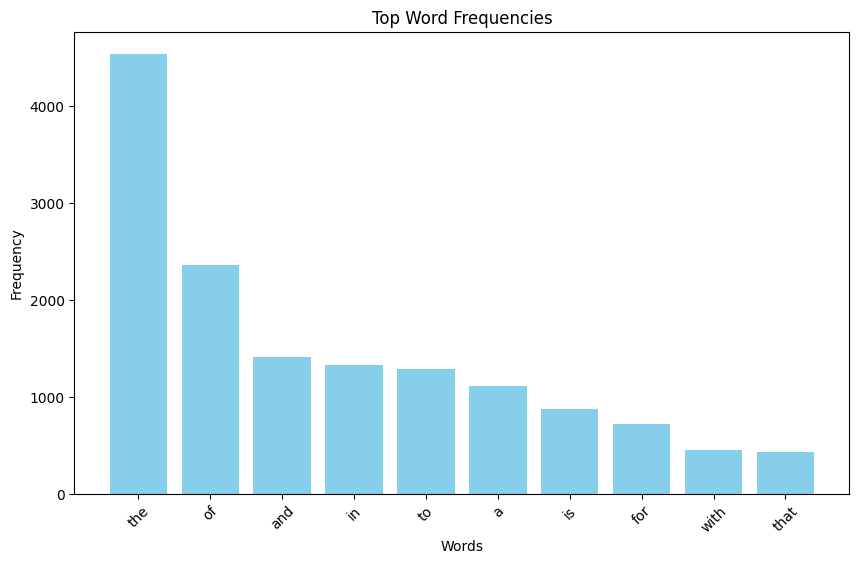

In [ ]:
import matplotlib.pyplot as plt

# Get the top N most common words and their frequencies
top_n = 10  # Change this to plot more or fewer words
top_word_freq = word_freq.most_common(top_n)

# Extract words and frequencies
words = [word for word, freq in top_word_freq]
frequencies = [freq for word, freq in top_word_freq]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title('Top Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [ ]:
pos_freq = Counter(pos_tags)
print("POS frequency :  ", pos_freq)

POS frequency :   Counter({'NN': 12250, 'IN': 8353, 'DT': 6792, 'JJ': 5892, 'NNS': 4368, 'VBN': 2487, 'RB': 1867, 'VBZ': 1712, 'CC': 1663, 'NNP': 1593, 'VB': 1411, 'CD': 1387, 'VBG': 1192, 'VBP': 1113, 'TO': 728, 'VBD': 633, 'PRP': 630, '_SP': 610, 'MD': 487, 'WDT': 368, 'PRP$': 210, 'WRB': 144, 'JJR': 139, 'JJS': 73, 'EX': 70, 'RBR': 68, 'RP': 62, 'RBS': 51, 'PDT': 40, 'FW': 36, 'NNPS': 19, 'WP': 11, 'XX': 11, 'WP$': 8, 'UH': 7, '.': 2, ':': 2, 'ADD': 2, '-RRB-': 1, "''": 1, 'LS': 1, '``': 1, '-LRB-': 1})


<ipython-input-27-37d6df6c87d2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_counts, y=pos_labels, palette='viridis')


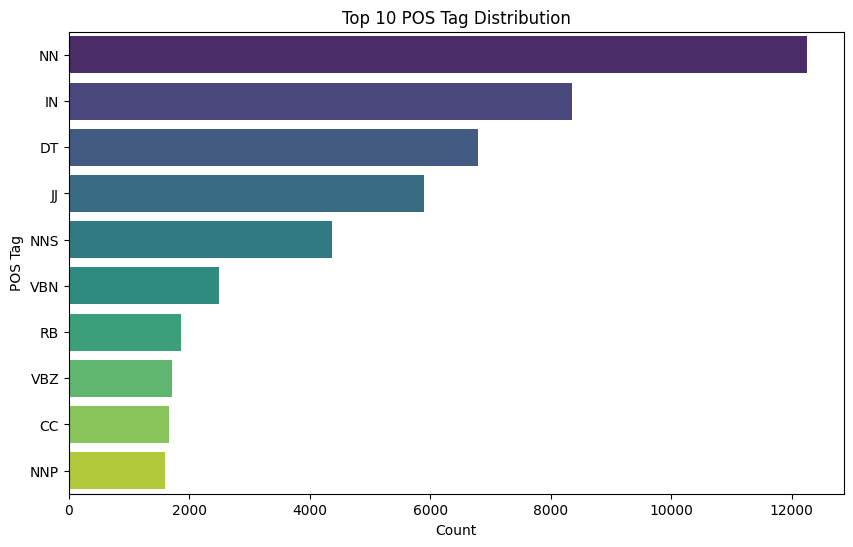

In [ ]:
plt.figure(figsize=(10, 6))
top_pos = pos_freq.most_common(10)
pos_labels, pos_counts = zip(*top_pos)
sns.barplot(x=pos_counts, y=pos_labels, palette='viridis')
plt.title('Top 10 POS Tag Distribution')
plt.xlabel('Count')
plt.ylabel('POS Tag')
plt.show()

In [ ]:
entity_freq = Counter(entities)
print('NER ferquency :  ', entity_freq)

NER ferquency :   Counter({'CARDINAL': 1049, 'DATE': 269, 'ORG': 157, 'PERSON': 125, 'ORDINAL': 106, 'GPE': 44, 'PRODUCT': 29, 'QUANTITY': 28, 'NORP': 22, 'LAW': 17, 'FAC': 9, 'LOC': 6, 'TIME': 5, 'LANGUAGE': 2, 'WORK_OF_ART': 1, 'MONEY': 1, 'PERCENT': 1})


<ipython-input-29-fc4535e36fcd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entity_counts, y=entity_labels, palette='magma')


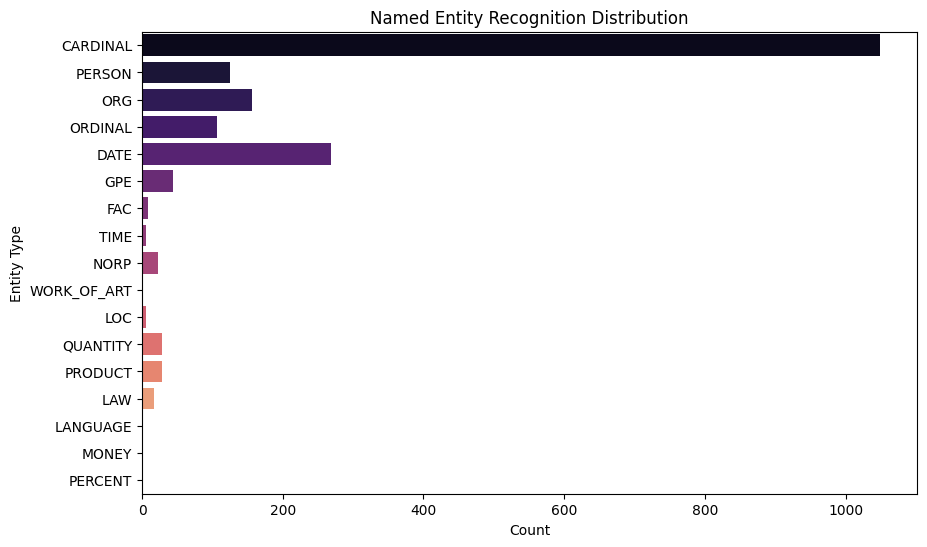

In [ ]:
plt.figure(figsize=(10, 6))
entity_labels, entity_counts = zip(*entity_freq.items())
sns.barplot(x=entity_counts, y=entity_labels, palette='magma')
plt.title('Named Entity Recognition Distribution')
plt.xlabel('Count')
plt.ylabel('Entity Type')
plt.show()

<ipython-input-30-aa64b3fe098e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keyword_counts, y=keyword_labels, palette='viridis')


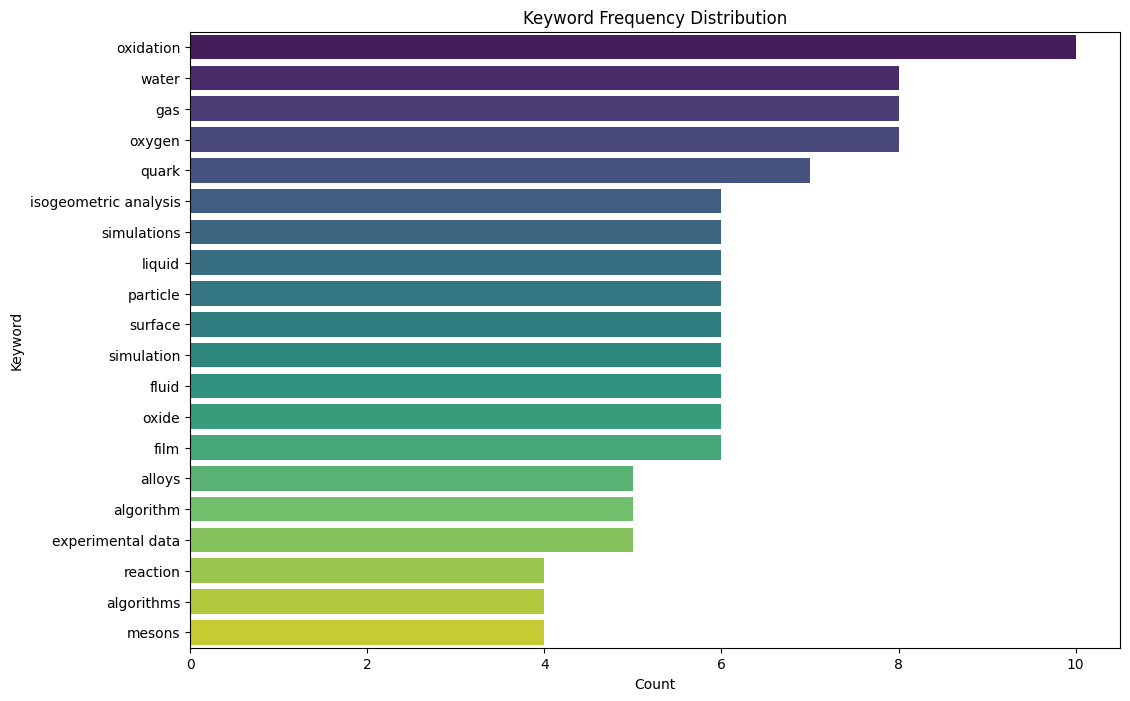

In [ ]:
# Extract keywords from JSON data
keywords = []
for filename, data in json_data.items():
    keywords.extend(data['keywords'].keys())

# Calculate keyword frequency
keyword_freq = Counter(keywords)

# Plot keyword frequency distribution
plt.figure(figsize=(12, 8))
top_keywords = keyword_freq.most_common(20)
keyword_labels, keyword_counts = zip(*top_keywords)
sns.barplot(x=keyword_counts, y=keyword_labels, palette='viridis')
plt.title('Keyword Frequency Distribution')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()


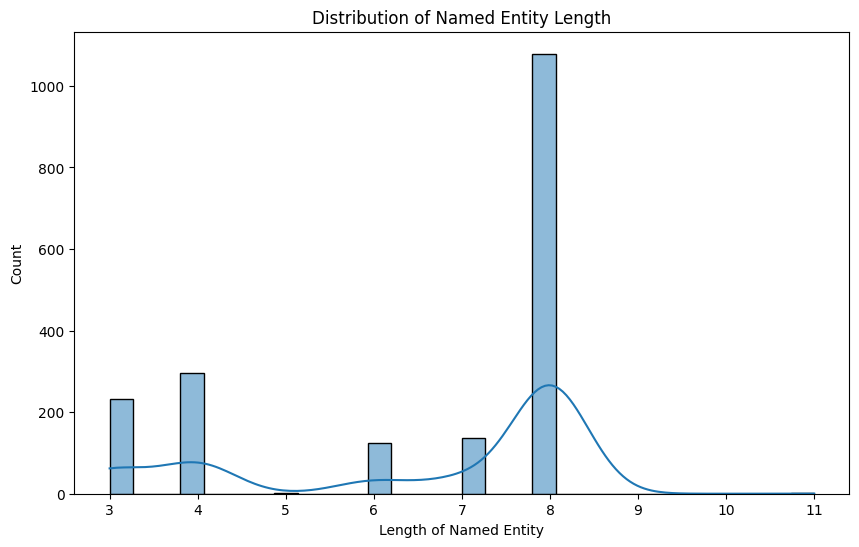

In [ ]:
# Calculate length of each named entity
ner_lengths = [len(entity) for entity in entities]

# Plot distribution of named entity length
plt.figure(figsize=(10, 6))
sns.histplot(ner_lengths, bins=30, kde=True)
plt.title('Distribution of Named Entity Length')
plt.xlabel('Length of Named Entity')
plt.ylabel('Count')
plt.show()


# SVM

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.chunk import RegexpParser
from random import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.util import ngrams
from sklearn.metrics import precision_recall_fscore_support as score
from nltk.util import everygrams
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.metrics.scores import accuracy, precision, recall, f_measure
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
import collections
import os
import re
import json

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def read_json_file(path):
    # Opening JSON file
    f = open(path)
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    text_value = dict()
    for key in data:
      val = data.get(key)
      text = val['text']
      value = val['keywords']
      text_value[text] = value
    return text_value


In [ ]:
def get_candidate_phrases(file):
    #Tokenize
    tokens = word_tokenize(file)
    # Chunking
    tagged = nltk.pos_tag(tokens)
    '''
    chunkGram = r""" PHRASE:
                        {(*  * )* *}
                """
    '''
    chunkGram = r"""
    PHRASE: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}
    """

    chunkParser = RegexpParser(chunkGram)
    chunked = chunkParser.parse(tagged)

    candidate_keywords = []
    for tree in chunked.subtrees():
        if tree.label() == 'PHRASE':
            candidate_keyword = ' '.join([x for x,y in tree.leaves()])
            candidate_keywords.append(candidate_keyword)
    candidate_keywords = [w for w in candidate_keywords if len(w) > 3 and len(w.split(' ')) < 10 and w.isalpha() ]
    return candidate_keywords

In [ ]:
embeddings_index = {}
f = open(glove_embedding_path, encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()
print('Found %s word vectors.' % len(embeddings_index))

400000it [00:43, 9097.76it/s]

Found 400000 word vectors.


In [ ]:
# ML model cannot recognise words, so we are finding word embedding using glove

In [ ]:
def create_phrase_vec(phrase):
  M = []
  for w in phrase:
    try:
      M.append(embeddings_index[w])
    except:
      continue
  M = np.array(M)
  v = M.sum(axis=0)
  if type(v) != np.ndarray:
    return np.zeros(300)
  return  v / np.sqrt((v ** 2).sum())

In [ ]:
def create_features(doc,phrase,candidate_list):
  features = {}
  features['length'] = len(phrase.split(' '))
  features['part_of_speech'] = ' '.join([pos for word,pos in nltk.pos_tag(nltk.word_tokenize(phrase))])
  phrase_list = create_phrase_vec(phrase)
  if len(phrase_list):
    for i in range(0,len(phrase_list)):
      features['vector' + str(i)] = phrase_list[i]
  position_list = [ m.start()/float(len(doc)) for m in re.finditer(re.escape(phrase),doc,flags=re.IGNORECASE)]
  if len(position_list):
      for i in range(0,len(position_list)):
          features['occurrance' + str(i)] = position_list[i]
  features['frequency'] = len(position_list)/ float(len(set(candidate_list)))
  return features


In [ ]:
def create_feature_list(train_path, class_mapping):
  feature_list = []
  features = read_json_file(train_path)
  candidate_list = []
  for text, value in tqdm(features.items()):
    candidates = get_candidate_phrases(text)
    candidate_list += candidates
    keywords =  list(value.keys())
    classes = list(value.values())
    for cd in candidates:
      feature = create_features(text,cd,candidates)
      if cd in keywords:
        tag = value.get(cd)[0][2]
        label = class_mapping[tag]
      else:
        label = class_mapping['Normal']
      feature_list.append([feature,label])
  return  feature_list


feature extraction like length, POS, frequency, position

In [ ]:
class_mapping = {
 'Normal': 0,
 'Task' : 1,
 'Process' : 2,
 'Material': 3
}


In [ ]:
feature_list = create_feature_list(train_path, class_mapping)
print(" ")
print('Length of feature list',len(feature_list))


100%|██████████| 350/350 [00:14<00:00, 24.91it/s]

 
Length of feature list 3725


these components together form a pipeline for extracting candidate phrases from scientific documents and generating features for classification tasks. The extracted features can be used to train machine learning models for key phrase extraction and classification.

In [ ]:
print(feature_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print('number of keywords', len([x for x,y in feature_list if y != 0]))
print('number of Task keywords', len([x for x,y in feature_list if y == 1]))
print('number of Process keywords', len([x for x,y in feature_list if y == 2]))
print('number of Material keywords', len([x for x,y in feature_list if y == 3]))
print('number of non keywords', len([x for x,y in feature_list if y == 0]))

number of keywords 523
number of Task keywords 23
number of Process keywords 145
number of Material keywords 355
number of non keywords 3202


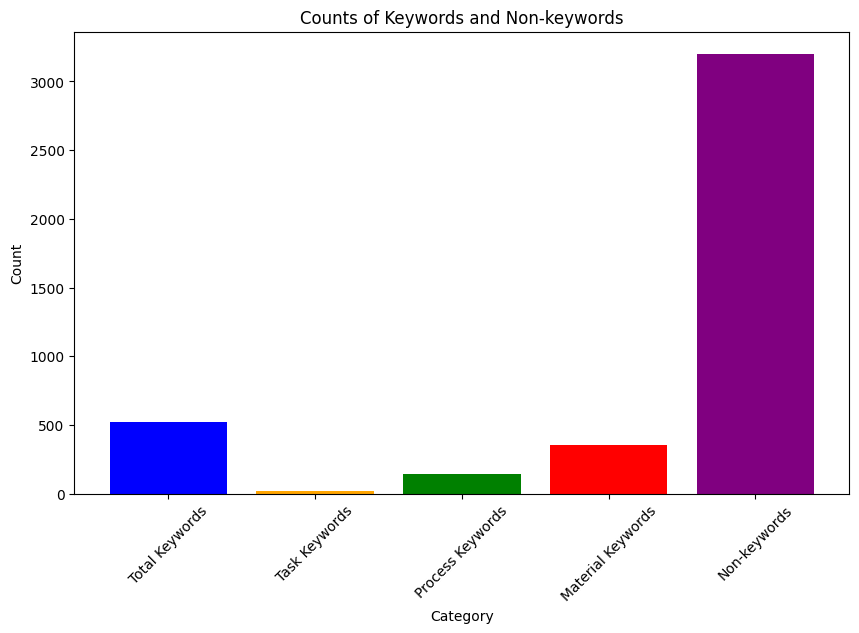

In [ ]:
counts = {
    'Total Keywords': len([x for x, y in feature_list if y != 0]),
    'Task Keywords': len([x for x, y in feature_list if y == 1]),
    'Process Keywords': len([x for x, y in feature_list if y == 2]),
    'Material Keywords': len([x for x, y in feature_list if y == 3]),
    'Non-keywords': len([x for x, y in feature_list if y == 0])
}

# Plot
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Counts of Keywords and Non-keywords')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
shuffle(feature_list)
non_candidates_list_train = [(x,y) for x,y in feature_list if y == 0][:500]
task_list_train = [(x,y) for x,y in feature_list if y == 1][:41]
process_list_train = [(x,y) for x,y in feature_list if y == 2][:278]
material_list_train = [(x,y) for x,y in feature_list if y == 3][:500]
shuffle(non_candidates_list_train)
shuffle(task_list_train)
shuffle(process_list_train)
shuffle(material_list_train)
training_set = []
training_set.extend(non_candidates_list_train)
training_set.extend(task_list_train)
training_set.extend(process_list_train)
training_set.extend(material_list_train)

Shuffling the list ensures that the order of samples does not bias the learning algorithm during training.

In some cases, there might be an imbalance in the number of samples across different classes.

In [ ]:
feature_list = np.array(feature_list)
X = feature_list[:,0]
Y = feature_list[:,1]

In [ ]:
print(feature_list)

[[{'length': 1, 'part_of_speech': 'NN', 'vector0': -0.055637836, 'vector1': -0.012807979, 'vector2': -0.06584488, 'vector3': -0.043101545, 'vector4': -0.12830627, 'vector5': 0.0068781325, 'vector6': -0.041872375, 'vector7': 0.03488868, 'vector8': -0.069830276, 'vector9': -0.2993697, 'vector10': 0.045308404, 'vector11': 0.02353862, 'vector12': -0.10258644, 'vector13': 0.020207705, 'vector14': -0.012297393, 'vector15': -0.02082913, 'vector16': -0.074061856, 'vector17': 0.05076014, 'vector18': 0.055267926, 'vector19': -0.03658058, 'vector20': -0.059363768, 'vector21': -0.015036683, 'vector22': 0.0019225199, 'vector23': 0.017614098, 'vector24': -0.02635392, 'vector25': -0.02746934, 'vector26': 0.028682139, 'vector27': 0.0024885074, 'vector28': 0.062729895, 'vector29': -0.049919963, 'vector30': -0.026833164, 'vector31': 0.095535696, 'vector32': -0.06624851, 'vector33': -0.0313953, 'vector34': -0.17071581, 'vector35': 0.029847387, 'vector36': 0.027089942, 'vector37': -0.051611878, 'vector38'

In [ ]:
print(X)

[{'length': 1, 'part_of_speech': 'NN', 'vector0': -0.055637836, 'vector1': -0.012807979, 'vector2': -0.06584488, 'vector3': -0.043101545, 'vector4': -0.12830627, 'vector5': 0.0068781325, 'vector6': -0.041872375, 'vector7': 0.03488868, 'vector8': -0.069830276, 'vector9': -0.2993697, 'vector10': 0.045308404, 'vector11': 0.02353862, 'vector12': -0.10258644, 'vector13': 0.020207705, 'vector14': -0.012297393, 'vector15': -0.02082913, 'vector16': -0.074061856, 'vector17': 0.05076014, 'vector18': 0.055267926, 'vector19': -0.03658058, 'vector20': -0.059363768, 'vector21': -0.015036683, 'vector22': 0.0019225199, 'vector23': 0.017614098, 'vector24': -0.02635392, 'vector25': -0.02746934, 'vector26': 0.028682139, 'vector27': 0.0024885074, 'vector28': 0.062729895, 'vector29': -0.049919963, 'vector30': -0.026833164, 'vector31': 0.095535696, 'vector32': -0.06624851, 'vector33': -0.0313953, 'vector34': -0.17071581, 'vector35': 0.029847387, 'vector36': 0.027089942, 'vector37': -0.051611878, 'vector38':

In [ ]:
print(Y)

[0 0 0 ... 0 0 0]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [ ]:
X_train = np.array(X_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)
feature_list_train = np.concatenate((X_train,y_train),axis=1)
print('Train size',feature_list_train.shape)

X_test = np.array(X_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
feature_list_test = np.concatenate((X_test,y_test),axis=1)
print('Test size',feature_list_test.shape)


Train size (2980, 2)
Test size (745, 2)


In [ ]:
def evaluation_metric(y_test,y_pred):
  precision, recall, fscore, support = score(y_test, y_pred,average=None,labels=[0,1,2,3])
  print('Class Non Keyword: ')
  print('Precision: ',precision[0])
  print('Recall: ',recall[0])
  print('Fscore: ',fscore[0])
  print('support: ',support[0])
  print(' ')
  print('Class Task: ')
  print('Precision: ',precision[1])
  print('Recall: ',recall[1])
  print('Fscore: ',fscore[1])
  print('support: ',support[1])
  print(' ')
  print('Class Process: ')
  print('Precision: ',precision[2])
  print('Recall: ',recall[2])
  print('Fscore: ',fscore[2])
  print('support: ',support[2])
  print(' ')
  print('Class Material: ')
  print('Precision: ',precision[3])
  print('Recall: ',recall[3])
  print('Fscore: ',fscore[3])
  print('support: ',support[3])
  print(' ')
  print("Overall:")
  print("Micro averaged F score",f1_score(y_test, y_pred, average='micro'))
  print("Macro averaged F score",f1_score(y_test, y_pred, average='macro'))

In [ ]:
classifier =  SklearnClassifier(LinearSVC(max_iter=5000)).train(training_set)
y_pred = classifier.classify_many(feature_list_test[:,0])
y_test = feature_list_test[:,1].tolist()
print ("Accuracy : ",nltk.classify.accuracy(classifier,feature_list_test) * 100)
print(' ')
evaluation_metric(y_test, y_pred)

Accuracy :  73.95973154362416
 
Class Non Keyword: 
Precision:  0.9066427289048474
Recall:  0.7890625
Fscore:  0.8437761069340017
support:  640
 
Class Task: 
Precision:  0.0
Recall:  0.0
Fscore:  0.0
support:  5
 
Class Process: 
Precision:  0.45454545454545453
Recall:  0.1724137931034483
Fscore:  0.25000000000000006
support:  29
 
Class Material: 
Precision:  0.23163841807909605
Recall:  0.5774647887323944
Fscore:  0.3306451612903226
support:  71
 
Overall:
Micro averaged F score 0.7395973154362416
Macro averaged F score 0.35610531705608106


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


compared to others count of task is very less

In [ ]:
def create_test_feature_list(test_path, class_mapping):
  feature_list = []
  features = read_json_file(train_path)
  for text, value in tqdm(features.items()):
    candidates = get_candidate_phrases(text)
    keywords =  list(value.keys())
    classes = list(value.values())
    print(classes)

    for i,kw in enumerate(keywords):
      feature = create_features(text,kw,candidates)
      label = class_mapping[classes[i][0][2]]
      feature_list.append([feature,label])
      for cd in candidates:
        if cd not in keywords:
          feature = create_features(text,cd,candidates)
          label = class_mapping['Normal']
          feature_list.append([feature,label])
  return feature_list

In [ ]:
test_feature_list = create_feature_list(test_path,class_mapping)
test_feature_list = np.asarray(test_feature_list)
print(" ")
print('Length of test feature list',len(test_feature_list))

100%|██████████| 100/100 [00:03<00:00, 25.25it/s]

 
Length of test feature list 1272


In [ ]:
print("Accuracy : ",nltk.classify.accuracy(classifier,test_feature_list) * 100)
print(' ')
y_pred = classifier.classify_many(test_feature_list[:,0])
y_test = test_feature_list[:,1].tolist()
evaluation_metric(y_test,y_pred)

Accuracy :  73.5062893081761
 
Class Non Keyword: 
Precision:  0.8967280163599182
Recall:  0.8075506445672191
Fscore:  0.8498062015503876
support:  1086
 
Class Task: 
Precision:  0.0
Recall:  0.0
Fscore:  0.0
support:  12
 
Class Process: 
Precision:  0.15625
Recall:  0.08620689655172414
Fscore:  0.11111111111111112
support:  58
 
Class Material: 
Precision:  0.20229007633587787
Recall:  0.45689655172413796
Fscore:  0.2804232804232804
support:  116
 
Overall:
Micro averaged F score 0.735062893081761
Macro averaged F score 0.3103351482711948


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


draw back of this is task is not considered

so we can use data augmentation or sampling to increase the task count

# Sampling the feature list so that it wont get biased


In [ ]:
'''

from sklearn.model_selection import StratifiedShuffleSplit

n_samples =100

# Let's assume 'labels' is a list or array of labels corresponding to each entry in feature_list
labels = np.array([feature[0]['part_of_speech'] for feature in feature_list])

sss = StratifiedShuffleSplit(n_splits=1, test_size=n_samples/len(feature_list), random_state=0)

for train_index, test_index in sss.split(feature_list, labels):
    sampled_feature_list = feature_list[test_index]
    print(sampled_feature_list)
'''

"\n\nfrom sklearn.model_selection import StratifiedShuffleSplit\n\nn_samples =100\n\n# Let's assume 'labels' is a list or array of labels corresponding to each entry in feature_list\nlabels = np.array([feature[0]['part_of_speech'] for feature in feature_list])\n\nsss = StratifiedShuffleSplit(n_splits=1, test_size=n_samples/len(feature_list), random_state=0)\n\nfor train_index, test_index in sss.split(feature_list, labels):\n    sampled_feature_list = feature_list[test_index]\n    print(sampled_feature_list)\n"

In [ ]:
import numpy as np

# Assuming feature_list is already defined and is a NumPy array
print("Original feature_list:")
print(feature_list)

# Specify the number of samples you want
n_samples = 20

# Check if we have enough data
if n_samples > len(feature_list):
    print("Error: n_samples is greater than the available data points")
else:
    # Perform random sampling without replacement
    sampled_indices = np.random.choice(len(feature_list), size=n_samples, replace=False)
    sampled_feature_list = feature_list[sampled_indices]

    print(f"Randomly sampled {n_samples} elements:")
    print(sampled_feature_list)


Original feature_list:
[[{'length': 1, 'part_of_speech': 'NN', 'vector0': -0.055637836, 'vector1': -0.012807979, 'vector2': -0.06584488, 'vector3': -0.043101545, 'vector4': -0.12830627, 'vector5': 0.0068781325, 'vector6': -0.041872375, 'vector7': 0.03488868, 'vector8': -0.069830276, 'vector9': -0.2993697, 'vector10': 0.045308404, 'vector11': 0.02353862, 'vector12': -0.10258644, 'vector13': 0.020207705, 'vector14': -0.012297393, 'vector15': -0.02082913, 'vector16': -0.074061856, 'vector17': 0.05076014, 'vector18': 0.055267926, 'vector19': -0.03658058, 'vector20': -0.059363768, 'vector21': -0.015036683, 'vector22': 0.0019225199, 'vector23': 0.017614098, 'vector24': -0.02635392, 'vector25': -0.02746934, 'vector26': 0.028682139, 'vector27': 0.0024885074, 'vector28': 0.062729895, 'vector29': -0.049919963, 'vector30': -0.026833164, 'vector31': 0.095535696, 'vector32': -0.06624851, 'vector33': -0.0313953, 'vector34': -0.17071581, 'vector35': 0.029847387, 'vector36': 0.027089942, 'vector37': -

In [ ]:
X_sampled = sampled_feature_list[:,0]
Y_sampled = sampled_feature_list[:,1]

In [ ]:
# why i sampled to 50 because since the count of test is 23

In [ ]:
x_train_sampled, x_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, Y_sampled, test_size=0.2, random_state=42, stratify=Y_sampled)


In [ ]:
x_train_sampled = np.array(x_train_sampled).reshape(-1,1)
y_train_sampled = np.array(y_train_sampled).reshape(-1,1)
feature_list_train_sampled = np.concatenate((x_train_sampled,y_train_sampled),axis=1)
print('Train size',feature_list_train_sampled.shape)

x_test_sampled = np.array(x_test_sampled).reshape(-1,1)
y_test_sampled = np.array(y_test_sampled).reshape(-1,1)
feature_list_test_sampled = np.concatenate((x_test_sampled,y_test_sampled),axis=1)
print('Test size',feature_list_test_sampled.shape)

Train size (16, 2)
Test size (4, 2)


In [ ]:
classifier_sampled =  SklearnClassifier(LinearSVC(max_iter=5000)).train(training_set)
y_pred_sampled = classifier_sampled.classify_many(feature_list_test_sampled[:,0])
y_test_sampled = feature_list_test_sampled[:,1].tolist()
print ("Accuracy : ",nltk.classify.accuracy(classifier_sampled,feature_list_test_sampled) * 100)
print(' ')
evaluation_metric(y_test_sampled, y_pred_sampled)

Accuracy :  75.0
 
Class Non Keyword: 
Precision:  1.0
Recall:  0.6666666666666666
Fscore:  0.8
support:  3
 
Class Task: 
Precision:  0.0
Recall:  0.0
Fscore:  0.0
support:  0
 
Class Process: 
Precision:  0.0
Recall:  0.0
Fscore:  0.0
support:  0
 
Class Material: 
Precision:  0.5
Recall:  1.0
Fscore:  0.6666666666666666
support:  1
 
Overall:
Micro averaged F score 0.75
Macro averaged F score 0.7333333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Bi-LSTM

In [ ]:
import json
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, f1_score
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [ ]:
with open('json_data_train.json', 'r') as f:
  data = json.load(f)
f.close()
text = []
keywordsInValue = []
keywords = []
keywordType = []
maxLength = 0
maxKeywords = 0
for key in data.keys():
  if len(data[key]['text'].split()) > maxLength:
    maxLength = len(data[key]['text'].split())
  keywordsAndType = data[key]['keywords']
  keywords = list(keywordsAndType.keys())
  for word in keywords:
    wordArray = word.split()
    if len(wordArray) > 1:
      for splitWord in wordArray:
        keywordsAndType[splitWord] = keywordsAndType[word]
  keywords = list(keywordsAndType.keys())
  tokenizer = Tokenizer(keywords)
  tokenizer.fit_on_texts([data[key]['text']])
  tokens = [i for i in tokenizer.word_index.keys()]
  text.append(data[key]['text'])
  encodedKeywords = []
  for word in tokens:
    if word in keywords:
      typeOfKeyword = keywordsAndType[word][0][2]
      if typeOfKeyword == "Process":
        encodedKeywords.append(2)
      elif typeOfKeyword == "Material":
        encodedKeywords.append(3)
      elif typeOfKeyword == "Task":
        encodedKeywords.append(1)
    else:
      encodedKeywords.append(0)
  keywordsInValue.append(encodedKeywords)

In [ ]:
with open('/content/drive/MyDrive/Mini Project/test_bio_annotations.npy', 'rb') as f:
    annotation = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/Mini Project/test_bio_sentences.npy', 'rb') as f:
    text = np.load(f,allow_pickle=True)



In [ ]:
maxLength  = 0
for doc in text:
  if len(doc) > maxLength:
    maxLength = len(doc)
tag_to_ix = {"Task": 0, "Process": 1, "Material": 2, "O": 3}
keywordsInValue = [[tag_to_ix[w] for w in s] for s in annotation]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, padding = "post", truncating = "post", maxlen = maxLength)
y = pad_sequences(keywordsInValue, padding = "post", truncating = "post", maxlen = maxLength)
y = [to_categorical(i,num_classes = 4) for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train[0])

[  71 1751  537  901    1  829 1752   27  105   25    1  829   54 3392
   18    9 3393 3394 3395    4    1  581   27 1155  306  157   22    9
  220   58    1 1751  537    6    1  829   54    8  473  220   10    4
    1  473  220   27 1016  105   18    9  829  830   90  626    2 3396
   12 1146   13    2    6    9  252  723   90  626    2 3397   12  449
   13    4  198    1 1752   43  872 3398   15    9 1238    3 3399 3400
    2   84   27    9  109  537 1331    3 3401    6 3402  568    2   29
   96  967 3403    1 1753  143    4    5   73    7  580  396    3    1
  331  289    5    1  830 1754    2    9 1156   27  397  171    7    1
  105  473  220 1650    1  662    4    1 1156   27  132    7 1530    1
 3404    5    1  465    3 1457 3405    3 3406 1721 1077  325   22    1
  623  155  236  143    4    1 1156   27   17  109   17  271   25    1
  289    5    1  830 1754    4  140    1  813    2    1  473  220   27
  880   18    1 1611    5    1 1584    6   88    3    1  830  252    4
    5 

In [ ]:

embed = {}
f = open('/content/glove.6B.100d.txt','r')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype = "float32")
	embed [word] = coefs
f.close()


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embed.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print(X_train.shape)
print(np.array(y_train).shape)
keywordModel = Sequential()
keywordModel.add(Embedding(len(word_index) + 1, 100))
keywordModel.add(Bidirectional(LSTM(64, return_sequences = True,),merge_mode='concat'))
keywordModel.add(TimeDistributed(Dense(4, activation = "softmax")))
keywordModel.compile(loss="categorical_crossentropy", optimizer = "adam")
keywordModel.fit(X_train, np.array(y_train), batch_size = 32, epochs = 7, validation_split = 0.1)


(80, 312)
(80, 312, 4)
Epoch 1/7
3/3 [==============================] - 8s 941ms/step - loss: 1.3666 - val_loss: 1.3097
Epoch 2/7
3/3 [==============================] - 1s 354ms/step - loss: 1.2893 - val_loss: 1.2242
Epoch 3/7
3/3 [==============================] - 1s 346ms/step - loss: 1.1951 - val_loss: 1.1046
Epoch 4/7
3/3 [==============================] - 1s 334ms/step - loss: 1.0617 - val_loss: 0.9359
Epoch 5/7
3/3 [==============================] - 2s 569ms/step - loss: 0.8931 - val_loss: 0.8250
Epoch 6/7
3/3 [==============================] - 2s 683ms/step - loss: 0.7833 - val_loss: 0.6744
Epoch 7/7
3/3 [==============================] - 2s 704ms/step - loss: 0.6419 - val_loss: 0.5792


In [ ]:
from keras.preprocessing.text import Tokenizer

# Assuming you have your tokenizer object defined elsewhere (or define it here)
tokenizer = Tokenizer(num_words=None)  # You can set a limit on vocabulary size if needed
tokenizer.fit_on_texts(text)  # Fit the tokenizer on your training text data

# Now you can use the tokenizer for test data processing
tag_to_ix = {"Task": 0, "Process": 1, "Material": 2, "O": 3}
keywordsInValue = [[tag_to_ix[w] for w in s] for s in annotation]
XTest = tokenizer.texts_to_sequences(text)
XTest = pad_sequences(XTest, padding="post", truncating="post", maxlen=maxLength)
yTest = pad_sequences(keywordsInValue, padding="post", truncating="post", maxlen=maxLength)
yTest = [to_categorical(i, num_classes=4) for i in yTest]

In [ ]:
a = keywordModel.predict(XTest)
a = np.argmax(a, axis = -1)
flattened_actual = (np.argmax(np.array(yTest), axis = -1)).flatten()
flattened_output = a.flatten()
print(classification_report(flattened_actual, flattened_output))
print(f1_score(y_pred=flattened_actual, y_true=flattened_output,average = "macro"))

4/4 [==============================] - 2s 164ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     11768
           1       0.00      0.00      0.00      2404
           2       0.00      0.00      0.00      1765
           3       0.76      0.99      0.86     15263

    accuracy                           0.83     31200
   macro avg       0.43      0.48      0.45     31200
weighted avg       0.74      0.83      0.78     31200

0.45125544777571636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Transformer Model for Sequence Labeling

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Dropout, Input, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import numpy as np


In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
def create_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_classes):
    inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size+1, embed_dim)(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(embedding_layer)

    # You could add a TimeDistributed layer if you're handling sequences
    x = tf.keras.layers.TimeDistributed(Dense(num_classes, activation='softmax'))(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
with open('json_data_train.json', 'r') as f:
  data = json.load(f)
f.close()
text = []
keywordsInValue = []
keywords = []
keywordType = []
maxLength = 0
maxKeywords = 0
for key in data.keys():
  if len(data[key]['text'].split()) > maxLength:
    maxLength = len(data[key]['text'].split())
  keywordsAndType = data[key]['keywords']
  keywords = list(keywordsAndType.keys())
  for word in keywords:
    wordArray = word.split()
    if len(wordArray) > 1:
      for splitWord in wordArray:
        keywordsAndType[splitWord] = keywordsAndType[word]
  keywords = list(keywordsAndType.keys())
  tokenizer = Tokenizer(keywords)
  tokenizer.fit_on_texts([data[key]['text']])
  tokens = [i for i in tokenizer.word_index.keys()]
  text.append(data[key]['text'])
  encodedKeywords = []
  for word in tokens:
    if word in keywords:
      typeOfKeyword = keywordsAndType[word][0][2]
      if typeOfKeyword == "Process":
        encodedKeywords.append(2)
      elif typeOfKeyword == "Material":
        encodedKeywords.append(3)
      elif typeOfKeyword == "Task":
        encodedKeywords.append(1)
    else:
      encodedKeywords.append(0)
  keywordsInValue.append(encodedKeywords)

In [ ]:
with open('/content/drive/MyDrive/Mini Project/test_bio_annotations.npy', 'rb') as f:
    annotation = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/Mini Project/test_bio_sentences.npy', 'rb') as f:
    text = np.load(f,allow_pickle=True)

In [ ]:
maxLength  = 0
for doc in text:
  if len(doc) > maxLength:
    maxLength = len(doc)
tag_to_ix = {"Task": 0, "Process": 1, "Material": 2, "O": 3}
keywordsInValue = [[tag_to_ix[w] for w in s] for s in annotation]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, padding = "post", truncating = "post", maxlen = maxLength)
y = pad_sequences(keywordsInValue, padding = "post", truncating = "post", maxlen = maxLength)
y = [to_categorical(i,num_classes = 4) for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train[0])

[  71 1751  537  901    1  829 1752   27  105   25    1  829   54 3392
   18    9 3393 3394 3395    4    1  581   27 1155  306  157   22    9
  220   58    1 1751  537    6    1  829   54    8  473  220   10    4
    1  473  220   27 1016  105   18    9  829  830   90  626    2 3396
   12 1146   13    2    6    9  252  723   90  626    2 3397   12  449
   13    4  198    1 1752   43  872 3398   15    9 1238    3 3399 3400
    2   84   27    9  109  537 1331    3 3401    6 3402  568    2   29
   96  967 3403    1 1753  143    4    5   73    7  580  396    3    1
  331  289    5    1  830 1754    2    9 1156   27  397  171    7    1
  105  473  220 1650    1  662    4    1 1156   27  132    7 1530    1
 3404    5    1  465    3 1457 3405    3 3406 1721 1077  325   22    1
  623  155  236  143    4    1 1156   27   17  109   17  271   25    1
  289    5    1  830 1754    4  140    1  813    2    1  473  220   27
  880   18    1 1611    5    1 1584    6   88    3    1  830  252    4
    5 

In [ ]:
import numpy as np

# Assuming y_train is a list of arrays where each array is shaped (sequence_length, num_classes)
y_train = np.stack(y_train)
y_test = np.stack(y_test)  # Apply the same transformation to y_test if necessary

print("y_train shape:", y_train.shape)


y_train shape: (80, 312, 4)


In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [ ]:
!pip install tensorflow.keras.preprocessing.text

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.preprocessing.text (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.preprocessing.text


In [ ]:
import json
import csv
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Bidirectional, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
#import tensorflow_text as text

with open('json_data_train.json', 'r') as f:
    data = json.load(f)
f.close()
text = []
keywordsInValue = []
keywords = []
keywordType = []
maxLength = 0
maxKeywords = 0
for key in data.keys():
    if len(data[key]['text'].split()) > maxLength:
        maxLength = len(data[key]['text'].split())
    keywordsAndType = data[key]['keywords']
    keywords = list(keywordsAndType.keys())
    for word in keywords:
        wordArray = word.split()
        if len(wordArray) > 1:
            for splitWord in wordArray:
                keywordsAndType[splitWord] = keywordsAndType[word]
    keywords = list(keywordsAndType.keys())
    tokenizer = Tokenizer(keywords)
    tokenizer.fit_on_texts([data[key]['text']])
    tokens = [i for i in tokenizer.word_index.keys()]
    text.append(data[key]['text'])
    encodedKeywords = []
    for word in tokens:
        if word in keywords:
            typeOfKeyword = keywordsAndType[word][0][2]
            if typeOfKeyword == "Process":
                encodedKeywords.append(2)
            elif typeOfKeyword == "Material":
                encodedKeywords.append(3)
            elif typeOfKeyword == "Task":
                encodedKeywords.append(1)
        else:
            encodedKeywords.append(0)
    keywordsInValue.append(encodedKeywords)

with open('/content/drive/MyDrive/Mini Project/test_bio_annotations.npy', 'rb') as f:
    annotation = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/Mini Project/test_bio_sentences.npy', 'rb') as f:
    text = np.load(f,allow_pickle=True)

maxLength  = 0
for doc in text:
    if len(doc) > maxLength:
        maxLength = len(doc)

tag_to_ix = {"Task": 0, "Process": 1, "Material": 2, "O": 3}
keywordsInValue = [[tag_to_ix[w] for w in s] for s in annotation]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, padding = "post", truncating = "post", maxlen = maxLength)
y = pad_sequences(keywordsInValue, padding = "post", truncating = "post", maxlen = maxLength)
y = [to_categorical(i,num_classes = 4) for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

embed = {}
f = open('/content/glove.6B.100d.txt','r')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = "float32")
    embed [word] = coefs
f.close()

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embed.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

inputs = Input(shape=(maxLength,))
embedding_layer = Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False)(inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
x = MultiHeadAttention(num_heads=8, key_dim=100, dropout=0.1)(x, x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
outputs = Dense(4, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.1)

XTest = tokenizer.texts_to_sequences(text)
XTest = pad_sequences(XTest, padding="post", truncating="post", maxlen=maxLength)
yTest = pad_sequences(keywordsInValue, padding="post", truncating="post", maxlen=maxLength)
yTest = [to_categorical(i, num_classes=4) for i in yTest]

test_predictions = model.predict(XTest)
test_predictions = np.argmax(test_predictions, axis=-1)
flattened_actual = (np.argmax(np.array(yTest), axis=-1)).flatten()
flattened_output = test_predictions.flatten()
print(classification_report(flattened_actual, flattened_output))
# Print F1 score - consider 'macro' or 'weighted' for multi-class classification
print("F1 Score (Macro):", f1_score(y_true=flattened_actual, y_pred=flattened_output, average='macro'))
print("F1 Score (Weighted):", f1_score(y_true=flattened_actual, y_pred=flattened_output, average='weighted'))

# Print accuracy score
print("Accuracy Score:", accuracy_score(y_true=flattened_actual, y_pred=flattened_output))

Epoch 1/10
3/3 [==============================] - 17s 3s/step - loss: 2.6116 - accuracy: 0.2900 - val_loss: 2.2465 - val_accuracy: 0.3674
Epoch 2/10
3/3 [==============================] - 11s 3s/step - loss: 2.1518 - accuracy: 0.4820 - val_loss: 1.9648 - val_accuracy: 0.5064
Epoch 3/10
3/3 [==============================] - 14s 4s/step - loss: 1.8739 - accuracy: 0.4898 - val_loss: 1.6990 - val_accuracy: 0.3674
Epoch 4/10
3/3 [==============================] - 12s 3s/step - loss: 1.5740 - accuracy: 0.4282 - val_loss: 1.3280 - val_accuracy: 0.5064
Epoch 5/10
3/3 [==============================] - 14s 4s/step - loss: 1.2874 - accuracy: 0.5009 - val_loss: 1.0742 - val_accuracy: 0.6098
Epoch 6/10
3/3 [==============================] - 13s 4s/step - loss: 1.1704 - accuracy: 0.4586 - val_loss: 1.0512 - val_accuracy: 0.5785
Epoch 7/10
3/3 [==============================] - 14s 4s/step - loss: 1.0986 - accuracy: 0.5183 - val_loss: 1.0716 - val_accuracy: 0.5064
Epoch 8/10
3/3 [==================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM

In [ ]:
import json
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, f1_score
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [ ]:
with open('json_data_train.json', 'r') as f:
  data = json.load(f)
f.close()
text = []
keywordsInValue = []
keywords = []
keywordType = []
maxLength = 0
maxKeywords = 0
for key in data.keys():
  if len(data[key]['text'].split()) > maxLength:
    maxLength = len(data[key]['text'].split())
  keywordsAndType = data[key]['keywords']
  keywords = list(keywordsAndType.keys())
  for word in keywords:
    wordArray = word.split()
    if len(wordArray) > 1:
      for splitWord in wordArray:
        keywordsAndType[splitWord] = keywordsAndType[word]
  keywords = list(keywordsAndType.keys())
  tokenizer = Tokenizer(keywords)
  tokenizer.fit_on_texts([data[key]['text']])
  tokens = [i for i in tokenizer.word_index.keys()]
  text.append(data[key]['text'])
  encodedKeywords = []
  for word in tokens:
    if word in keywords:
      typeOfKeyword = keywordsAndType[word][0][2]
      if typeOfKeyword == "Process":
        encodedKeywords.append(2)
      elif typeOfKeyword == "Material":
        encodedKeywords.append(3)
      elif typeOfKeyword == "Task":
        encodedKeywords.append(1)
    else:
      encodedKeywords.append(0)
  keywordsInValue.append(encodedKeywords)

In [ ]:
with open('/content/drive/MyDrive/Mini Project/test_bio_annotations.npy', 'rb') as f:
    annotation = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/Mini Project/test_bio_sentences.npy', 'rb') as f:
    text = np.load(f,allow_pickle=True)


In [ ]:
maxLength  = 0
for doc in text:
  if len(doc) > maxLength:
    maxLength = len(doc)
tag_to_ix = {"Task": 0, "Process": 1, "Material": 2, "O": 3}
keywordsInValue = [[tag_to_ix[w] for w in s] for s in annotation]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, padding = "post", truncating = "post", maxlen = maxLength)
y = pad_sequences(keywordsInValue, padding = "post", truncating = "post", maxlen = maxLength)
y = [to_categorical(i,num_classes = 4) for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train[0])

[  71 1751  537  901    1  829 1752   27  105   25    1  829   54 3392
   18    9 3393 3394 3395    4    1  581   27 1155  306  157   22    9
  220   58    1 1751  537    6    1  829   54    8  473  220   10    4
    1  473  220   27 1016  105   18    9  829  830   90  626    2 3396
   12 1146   13    2    6    9  252  723   90  626    2 3397   12  449
   13    4  198    1 1752   43  872 3398   15    9 1238    3 3399 3400
    2   84   27    9  109  537 1331    3 3401    6 3402  568    2   29
   96  967 3403    1 1753  143    4    5   73    7  580  396    3    1
  331  289    5    1  830 1754    2    9 1156   27  397  171    7    1
  105  473  220 1650    1  662    4    1 1156   27  132    7 1530    1
 3404    5    1  465    3 1457 3405    3 3406 1721 1077  325   22    1
  623  155  236  143    4    1 1156   27   17  109   17  271   25    1
  289    5    1  830 1754    4  140    1  813    2    1  473  220   27
  880   18    1 1611    5    1 1584    6   88    3    1  830  252    4
    5 

In [ ]:
embed = {}
f = open('/content/glove.6B.100d.txt','r')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype = "float32")
	embed [word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embed.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print(X_train.shape)
print(np.array(y_train).shape)
keywordModel = Sequential()
keywordModel.add(Embedding(len(word_index) + 1, 100))
keywordModel.add(LSTM(64, return_sequences = True,))
keywordModel.add(TimeDistributed(Dense(4, activation = "softmax")))
keywordModel.compile(loss="categorical_crossentropy", optimizer = "adam")
keywordModel.fit(X_train, np.array(y_train), batch_size = 32, epochs = 10, validation_split = 0.1)

(80, 312)
(80, 312, 4)
Epoch 1/10
3/3 [==============================] - 5s 746ms/step - loss: 1.3725 - val_loss: 1.3224
Epoch 2/10
3/3 [==============================] - 1s 377ms/step - loss: 1.3051 - val_loss: 1.2490
Epoch 3/10
3/3 [==============================] - 1s 372ms/step - loss: 1.2227 - val_loss: 1.1483
Epoch 4/10
3/3 [==============================] - 2s 567ms/step - loss: 1.1074 - val_loss: 0.9970
Epoch 5/10
3/3 [==============================] - 2s 424ms/step - loss: 0.9443 - val_loss: 0.8591
Epoch 6/10
3/3 [==============================] - 1s 422ms/step - loss: 0.8139 - val_loss: 0.7673
Epoch 7/10
3/3 [==============================] - 1s 392ms/step - loss: 0.7268 - val_loss: 0.6829
Epoch 8/10
3/3 [==============================] - 1s 375ms/step - loss: 0.6587 - val_loss: 0.6495
Epoch 9/10
3/3 [==============================] - 1s 375ms/step - loss: 0.6271 - val_loss: 0.6269
Epoch 10/10
3/3 [==============================] - 1s 383ms/step - loss: 0.6050 - val_loss: 0.6

In [ ]:
# Assuming you have your tokenizer object defined elsewhere (or define it here)
tokenizer = Tokenizer(num_words=None)  # You can set a limit on vocabulary size if needed
tokenizer.fit_on_texts(text)  # Fit the tokenizer on your training text data

# Now you can use the tokenizer for test data processing
tag_to_ix = {"Task": 0, "Process": 1, "Material": 2, "O": 3}
keywordsInValue = [[tag_to_ix[w] for w in s] for s in annotation]
XTest = tokenizer.texts_to_sequences(text)
XTest = pad_sequences(XTest, padding="post", truncating="post", maxlen=maxLength)
yTest = pad_sequences(keywordsInValue, padding="post", truncating="post", maxlen=maxLength)
yTest = [to_categorical(i, num_classes=4) for i in yTest]

In [ ]:
a = keywordModel.predict(XTest)
a = np.argmax(a, axis = -1)
flattened_actual = (np.argmax(np.array(yTest), axis = -1)).flatten()
flattened_output = a.flatten()
print(classification_report(flattened_actual, flattened_output))
print(f1_score(y_pred=flattened_actual, y_true=flattened_output,average = "macro"))

4/4 [==============================] - 1s 111ms/step
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     11768
           1       0.00      0.00      0.00      2404
           2       0.00      0.00      0.00      1765
           3       0.72      1.00      0.84     15263

    accuracy                           0.81     31200
   macro avg       0.43      0.46      0.44     31200
weighted avg       0.73      0.81      0.76     31200

0.4410178144766367


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
